In [ ]:
!pip install mlxtend
!pip install efficient-apriori

In [1]:
import warnings, random

import datetime
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc
import matplotlib.pyplot as plt
import seaborn as sns

import efficient_apriori as efa
from mlxtend.frequent_patterns import apriori, association_rules, fpmax, hmine, fpcommon, fpgrowth
from mlxtend.preprocessing import TransactionEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm  # Para visualizar o progresso

warnings.filterwarnings('ignore')

In [2]:
def buildTransactionList(sales_df, transaction_type='cupom', min_size=1):
    transaction_data = []
    
    if transaction_type == 'cupom':
        transaction_data = sales_df.groupby(by=['COD_CUPOM_LOJA'])['COD_SKU'].apply(list)
    if transaction_type == 'customer':
        transaction_data = sales_df.groupby(by=['COD_CLIENTE'])['COD_SKU'].apply(list)

    transaction_data = transaction_data[transaction_data.apply(lambda x: len(x) >= min_size)]

    return transaction_data

def extract_rules_eff(transactions_df, min_support, min_threshold):
    transactions = [tuple(set(transaction)) for transaction in transactions_df.tolist()]
    itemsets, rules = efa.apriori(transactions, min_support=min_support, min_confidence=min_threshold)

    temp_df = []
    for rule in rules:
        rl = {
            'lhs':rule.lhs,
            'rhs':rule.rhs,
            'confidence':rule.confidence,
            'conviction':rule.conviction,
            'lift':rule.lift,
            'rpf':rule.rpf,
            'support':rule.support
        }

        temp_df.append(rl)

    temp_df = pd.DataFrame(temp_df)

    del transactions, itemsets, rules

    return temp_df    

def extract_rules(transactions_df, min_support, min_threshold, metric, algo='apriori'):
    
    # Assuming 'transaction_data' is a list of lists where each sublist contains SKUs bought in a transaction.
    te = TransactionEncoder()
    te_ary = te.fit(transactions_df).transform(transactions_df)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

    # Apply the apriori/fpgrowth algorithm
    if algo == 'apriori':
        frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
    else:
        frequent_itemsets = fpgrowth(df_encoded, min_support=min_support, use_colnames=True)

    # Generate association rules
    rules = association_rules(frequent_itemsets, metric=metric, min_threshold=min_threshold)

    del te, te_ary, df_encoded, frequent_itemsets

    return rules

'''
def get_suggestions(sku_list, rules_df):
    
    if not isinstance(rules_df['antecedents'].iloc[0], (list, tuple, set)):
        rules_df['antecedents'] = rules_df['antecedents'].apply(lambda x: eval(x) if isinstance(x, str) else x)
    
    filtered_rules = rules_df[rules_df['antecedents'].apply(lambda x: any(sku in x for sku in sku_list))]
    
    sorted_rules = filtered_rules.sort_values(by=['consequent support', 'confidence'], ascending=False)

    # Obter todos os SKUs sugeridos da coluna 'consequents'
    suggested_skus = sorted_rules['consequents'].explode().unique()
    
    # Selecionar no máximo 6 SKUs
    suggested_skus = suggested_skus[:6]
    
    return suggested_skus
'''
    
def get_suggestions(sku_list, rules_df, top_n=7):

    suggestions = pd.DataFrame(columns=['rhs', 'confidence', 'conviction', 'lift'])

    filtered_rules = rules_df[rules_df['lhs'].apply(lambda x: any(sku in x for sku in sku_list))]
    filtered_rules = filtered_rules.sort_values(by=['confidence', 'lift', 'conviction'], ascending=False)

    if filtered_rules.empty == False:
        suggestions = filtered_rules[['rhs', 'confidence', 'conviction', 'lift']].copy()
        
        # Remover SKUs já presentes na sku_list
        # suggestions = suggestions[~suggestions['rhs'].isin(sku_list)]

        # Expandir o 'rhs' caso contenha múltiplos itens
        suggestions = suggestions.explode('rhs')
        
        # Remover duplicatas baseadas no 'rhs'
        suggestions = suggestions.drop_duplicates(subset='rhs')
        
        # Selecionar apenas os top_n resultados
        suggestions = suggestions.head(top_n)
        
        # Resetar o índice para melhor apresentação
        suggestions = suggestions.reset_index(drop=True)
    
    return suggestions

def get_recommendations(suggestions_df, products_df, discount):
    # Verificar se o desconto está entre 0 e 1
    if not 0 <= discount <= 1:
        raise ValueError("O desconto deve ser um valor decimal entre 0 e 1 (por exemplo, 0.10 para 10%)")
    
    # Mesclar suggestions_df com products_df com base na correspondência de 'rhs' e 'COD_SKU'
    merged_df = suggestions_df.merge(products_df, left_on='rhs', right_on='COD_SKU', how='left')
    
    # Verificar se a mesclagem resultou em produtos correspondentes
    if merged_df.empty:
        #print("Nenhum produto correspondente encontrado para as sugestões fornecidas.")
        return merged_df
    
    # Aplicar o desconto ao preço regular e adicionar nova coluna
    merged_df['PRECO_COM_DESCONTO'] = merged_df['PRECO_REGULAR_AVG'] * (1 - discount)
    
    # Selecionar as colunas desejadas
    columns_to_return = ['COD_SKU', 'SKU', 'CATEGORIA_SKU', 'PRECO_REGULAR_AVG', 'PRECO_COM_DESCONTO']
    recommended_products = merged_df[columns_to_return]
    
    return recommended_products

def evalSuggestions(sales_test, products, rules):
    """
    Avalia o desempenho das recomendações geradas pelas regras de associação.
    
    Parâmetros:
    - sales_test: DataFrame contendo as vendas reais no conjunto de teste.
    - rules: DataFrame contendo as regras de associação.

    Retorna:
    - metrics_df: DataFrame com as métricas de avaliação calculadas.
    """
    # Lista para armazenar as métricas
    metrics_list = []

    # Agrupar as compras por cupom
    grouped_sales = sales_test.groupby('COD_CUPOM_LOJA')

    # Iterar sobre cada cupom
    for cod_cupom, group in tqdm(grouped_sales, desc='Avaliando Recomendações'):
        #for cod_cupom in sales_test.groupby('COD_CUPOM'):

        # Produtos comprados pelo cliente neste período
        purchased_products = group['COD_SKU'].unique().tolist()

        # Simular o carrinho atual (pode ser os produtos comprados anteriormente)
        # Aqui, assumimos que o cliente já comprou alguns produtos e queremos recomendar adicionais
        # Para simplificar, vamos assumir que o carrinho está vazio ou usar os produtos do cliente no conjunto de treinamento
        #cart = purchased_products  # Aqui você pode customizar como obter o carrinho do cliente

        cart = random.sample(purchased_products, int(len(purchased_products)*1))
        target_products = cart#[p for p in purchased_products if p not in cart ]

        # Gerar sugestões com base no carrinho e nas regras
        suggestions = get_suggestions(cart, rules)

        # Obter as recomendações (DataFrame)
        recommendations_df = get_recommendations(suggestions, products, discount=.05)
        recommended_products = recommendations_df['COD_SKU'].unique().tolist()

        # Se não houver recomendações, pular para evitar divisões por zero
        if not recommended_products:
            continue

        
        target_set = set(target_products)
        recommended_set = set(recommended_products)
        all_products = list(target_set.union(recommended_set))

        y_true = [1 if sku in target_set else 0 for sku in all_products]
        y_pred = [1 if sku in recommended_set else 0 for sku in all_products]


        # Calcular métricas
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        accuracy = accuracy_score(y_true, y_pred)

        # Armazenar as métricas
        metrics_list.append({
            'COD_CUPOM': cod_cupom,
            'COD_CLIENTE': group['COD_CLIENTE'].unique()[0],
            'items':len(purchased_products),
            'precision': precision,
            'recall': recall,
            'f1-score': f1,
            'accuracy': accuracy,
            'recommendations': len(recommended_products),
            'relevant': sum(y_true),
            'purchased_products':purchased_products,
            'recommended_products':recommended_products
        })

    # Converter a lista de métricas em DataFrame
    metrics_df = pd.DataFrame(metrics_list, columns=['COD_CUPOM','COD_CLIENTE','items','precision','recall','f1-score','accuracy','recommendations','relevant','purchased_products','recommended_products'])

    # Calcular as métricas médias
    avg_metrics = metrics_df[['precision', 'recall', 'f1-score', 'accuracy']].mean().to_dict()
    print("Métricas Médias:")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.4f}")

    return metrics_df, avg_metrics



def splitTrainTestData(sales_df, column, test_size=.2):

    cupons_list = sales_df[column].unique()
    sales_train, sales_test =  train_test_split(cupons_list, test_size=test_size, random_state=36)

    sales_train = sales_df[sales_df['COD_CUPOM_LOJA'].isin(sales_train)]
    sales_test = sales_df[sales_df['COD_CUPOM_LOJA'].isin(sales_test)]

    return sales_train, sales_test

In [3]:
path = 'D:/Disco/Data/PUCRS/proj CDIA III/'

tables = ['VW_PUC_VENDAS', 'PUC_CAMPANHAS']

In [4]:
vendas_dataset = pq.ParquetDataset(f'{path}/dataset-ii/{tables[0]}')
#campanhas_dataset = pq.ParquetDataset(f'{path}/dataset/{tables[1]}')

In [5]:
vendas = vendas_dataset.read()
#campanhas = campanhas_dataset.read_pandas()

In [6]:
cod_cupom = pc.cast(pc.cast(vendas['COD_CUPOM'], pa.int32()), pa.string())
cod_loja = pc.cast(pc.cast(vendas['COD_LOJA'], pa.int32()), pa.string())
sep = pa.array(['-'] * len(vendas))

vendas = vendas.drop_columns(['COD_CUPOM', 'COD_LOJA', 'CLIENTE_FISICO_JURIDICO', 'SEXO_CLIENTE', 'DTNASCIMENTO_CLIENTE', 'UF_CIDADE', 'COD_CIDADE', 'NOME_CIDADE'])

vendas = vendas.append_column('COD_CUPOM', cod_cupom)
vendas = vendas.append_column('COD_LOJA', cod_loja)
vendas = vendas.append_column('COD_CUPOM_LOJA', pc.binary_join_element_wise(cod_cupom, cod_loja, sep))


In [7]:
vendas = vendas.to_pandas()

max_cod = vendas['COD_CLIENTE'].max()
mask_zero = (vendas['COD_CLIENTE'] == 0) | (pd.isna(vendas['COD_CLIENTE']))
loc_cupom = vendas.loc[mask_zero, 'COD_CUPOM_LOJA']
unique_cod_cupom = loc_cupom.unique()
cod_clientes = np.arange(max_cod + 1, max_cod + len(unique_cod_cupom) + 1, dtype=int)

map_codes = dict(zip(unique_cod_cupom, cod_clientes))
vendas.loc[mask_zero, 'COD_CLIENTE'] = vendas.loc[mask_zero, 'COD_CUPOM_LOJA'].map(map_codes)

vendas['COD_CLIENTE'] = vendas['COD_CLIENTE'].astype(int)

del max_cod, mask_zero, loc_cupom, unique_cod_cupom, cod_clientes, map_codes

In [8]:
vendas.columns

Index(['COD_CLIENTE', 'COD_SKU', 'SKU', 'CATEGORIA_SKU', 'SUBCATEGORIA_SKU',
       'DATA_CUPOM', 'UNIDADES', 'IDENTIFICADOR_PROMOCIONAL', 'PRECO_REGULAR',
       'TOTAL_DESCONTO', 'TOTAL_BRUTO', 'TOTAL_LIQUIDO', 'COD_CUPOM',
       'COD_LOJA', 'COD_CUPOM_LOJA'],
      dtype='object')

In [9]:
vendas_df = vendas[['COD_CUPOM', 'COD_LOJA', 'COD_CUPOM_LOJA', 'COD_CLIENTE', 'COD_SKU', 'SKU', 'CATEGORIA_SKU', 'SUBCATEGORIA_SKU',
       'UNIDADES', 'PRECO_REGULAR', 'TOTAL_DESCONTO', 'TOTAL_BRUTO', 'TOTAL_LIQUIDO']]

In [10]:
vendas_df

,COD_CUPOM,COD_LOJA,COD_CUPOM_LOJA,COD_CLIENTE,COD_SKU,SKU,CATEGORIA_SKU,SUBCATEGORIA_SKU,UNIDADES,PRECO_REGULAR,TOTAL_DESCONTO,TOTAL_BRUTO,TOTAL_LIQUIDO
0,145504,1001,145504-1001,82432084,100020796,FLANCOX 500MG 14CP REV APSEN,MEDICAMENTOS,REFERENCIA,1.0,49.02,0.00,49.02,49.02
1,145504,1001,145504-1001,82432084,10037505,PRINCIPIA MIX-01 SERUM ANTI-ACNE 30ML,DERMO-COSMETICOS,DERMO-COSMETICOS,1.0,59.00,0.00,59.00,59.00
2,145504,1001,145504-1001,82432084,10098469,"OCTIFEN COLIRIO 0,25",MEDICAMENTOS,REFERENCIA,1.0,35.51,0.00,35.51,35.51
3,146406,1001,146406-1001,82405769,10094193,PREDSIM 20ML GOTAS MANTECORP,MEDICAMENTOS,REFERENCIA SUPER ONEROSOS,1.0,42.34,5.08,42.34,37.26
4,146406,1001,146406-1001,82405769,10094193,PREDSIM 20ML GOTAS MANTECORP,MEDICAMENTOS,REFERENCIA SUPER ONEROSOS,1.0,42.34,5.08,42.34,37.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11962993,500563,988,500563-988,40570262,10089574,VICK PYRENA 5G ENV MACA/CANELA A,MEDICAMENTOS,REFERENCIA AVULSO,4.0,4.69,0.00,18.76,18.76
11962994,500563,988,500563-988,40570262,10102420,CARGA GILLETTE MACH3,PERFUMARIA,PERFUMARIA,1.0,29.90,0.00,29.90,29.90
11962995,500563,988,500563-988,40570262,10102420,CARGA GILLETTE MACH3,PERFUMARIA,PERFUMARIA,1.0,29.90,0.00,29.90,29.90
11962996,500563,988,500563-988,40570262,100000055,BENEGRIP 20CP REV HYPERA PHARMA,MEDICAMENTOS,REFERENCIA ONEROSOS,1.0,41.97,6.30,41.97,35.67


In [11]:
units = vendas.groupby(['COD_CLIENTE', 'COD_CUPOM_LOJA'])['UNIDADES'].sum().reset_index()
skus = vendas.groupby(['COD_CLIENTE', 'COD_CUPOM_LOJA'])['COD_SKU'].nunique().reset_index()
cupom_df = units.merge(skus, on=['COD_CLIENTE', 'COD_CUPOM_LOJA'])

del units, skus

In [12]:
cupom_df

,COD_CLIENTE,COD_CUPOM_LOJA,UNIDADES,COD_SKU
0,120,513894-693,2.0,2
1,250,797045-77,1.0,1
2,250,800862-77,3.0,3
3,250,802754-77,1.0,1
4,250,809563-77,1.0,1
...,...,...,...,...
4099919,94980992,455250-988,1.0,1
4099920,94980993,455584-988,1.0,1
4099921,94980994,434588-988,1.0,1
4099922,94980995,434583-988,1.0,1


In [13]:
cod_clientes = vendas.groupby('COD_CLIENTE')['COD_CUPOM'].nunique().reset_index()
cod_clientes.rename(columns={'COD_CUPOM':'n_cupom'}, inplace=True)

n_items = vendas.groupby(['COD_CLIENTE', 'COD_CUPOM'])['UNIDADES'].sum().reset_index()
n_items.rename(columns={'UNIDADES': 'n_items'}, inplace=True)

avg_items = n_items.groupby('COD_CLIENTE')['n_items'].mean().reset_index()
avg_items.rename(columns={'n_items': 'avg_items'}, inplace=True)

n_items = n_items.groupby('COD_CLIENTE')['n_items'].sum().reset_index()

n_skus = vendas.groupby('COD_CLIENTE')['COD_SKU'].nunique().reset_index()
n_skus.rename(columns={'COD_SKU':'n_skus'}, inplace=True)

total_sum = vendas.groupby('COD_CLIENTE')['TOTAL_LIQUIDO'].sum().reset_index()
total_sum.rename(columns={'TOTAL_LIQUIDO':'total_sum'}, inplace=True)

avg_cupom = total_sum.merge(cod_clientes, on='COD_CLIENTE')
avg_cupom['avg_cupom'] = avg_cupom['total_sum'] / avg_cupom['n_cupom']

#clientes_features = cod_clientes.merge(n_skus, on='COD_CLIENTE')
clientes_features = cod_clientes.merge(avg_items, on='COD_CLIENTE')
clientes_features = clientes_features.merge(n_items, on='COD_CLIENTE')
clientes_features = clientes_features.merge(n_skus, on='COD_CLIENTE')
clientes_features = clientes_features.merge(avg_cupom[['COD_CLIENTE', 'avg_cupom', 'total_sum']], on='COD_CLIENTE')

del cod_clientes, n_items, avg_items, n_skus, total_sum, avg_cupom

clientes_features

,COD_CLIENTE,n_cupom,avg_items,n_items,n_skus,avg_cupom,total_sum
0,120,1,2.0,2.0,2,25.990,25.99
1,250,10,2.3,23.0,19,80.183,801.83
2,253,2,2.5,5.0,5,56.755,113.51
3,408,1,19.0,19.0,6,171.080,171.08
4,460,2,1.5,3.0,3,25.095,50.19
...,...,...,...,...,...,...,...
1474961,94980992,1,1.0,1.0,1,11.990,11.99
1474962,94980993,1,1.0,1.0,1,19.900,19.90
1474963,94980994,1,1.0,1.0,1,10.000,10.00
1474964,94980995,1,1.0,1.0,1,20.990,20.99


In [15]:
sales_train, sales_test = splitTrainTestData(vendas, 'COD_CUPOM_LOJA', test_size=.2)

In [16]:
transaction_data = buildTransactionList(vendas, transaction_type='cupom', min_size=2)


In [17]:
transaction_df = pd.DataFrame(transaction_data).reset_index()

In [18]:
transaction_df

,COD_CUPOM_LOJA,COD_SKU
0,10-190,"[10033487, 10033487]"
1,100-130,"[10086048, 10086048]"
2,100-190,"[100026502, 100026503, 10033694, 10032947]"
3,1000-1075,"[100023059, 100023059, 10027966, 10027966, 100..."
4,1000-190,"[10096431, 95244, 10007094]"
...,...,...
2538991,99998-501,"[10005577, 100017853, 10032433, 10030684, 1000..."
2538992,99999-1101,"[10035339, 10035339, 100001424, 100001424, 100..."
2538993,99999-1264,"[6833, 10022964]"
2538994,99999-1278,"[10104004, 10031088]"


In [14]:
products = produtos = vendas.groupby(['COD_SKU', 'SKU', 'CATEGORIA_SKU', 'SUBCATEGORIA_SKU'], as_index=False).agg({'PRECO_REGULAR': 'mean'})
products.rename(columns={'PRECO_REGULAR': 'PRECO_REGULAR_AVG'}, inplace=True)
products

,COD_SKU,SKU,CATEGORIA_SKU,SUBCATEGORIA_SKU,PRECO_REGULAR_AVG
0,7,SERVICO EM DOMICILIO,DIVERSOS,SERVICOS TELE ENTREGA,5.000000
1,10,MANIPULADOS,MANIPULADOS,MANIPULADOS MEDICAMENTOS,0.010000
2,11,SERVICO DE APLICACAO DE INJETAVEIS,SERVICOS,SERVICOS FARMACEUTICOS,5.000000
3,12,SERVICO DE GESTO VACINAL GRIPE CONVENIOS,SERVICOS,SERVICOS FARMACEUTICOS,7.921640
4,13,SERVICO DE VERIFICACAO DE GLICEMIA CAPIL,SERVICOS,SERVICOS FARMACEUTICOS,3.000000
...,...,...,...,...,...
20653,100027853,ESC CAB MARCO BONI 7,PERFUMARIA,PERFUMARIA,14.990000
20654,100027855,ESC CAB MARCO BONI 8,PERFUMARIA,PERFUMARIA,29.990000
20655,100027878,NEBULIZADOR PULMOMAI,MEDICAMENTOS,LIBERADOS,219.900000
20656,100027882,AMPOLA PANTENE 3UN NUTRE,PERFUMARIA,PERFUMARIA,27.887918


In [19]:
products

,COD_SKU,SKU,CATEGORIA_SKU,SUBCATEGORIA_SKU,PRECO_REGULAR_AVG
0,7,SERVICO EM DOMICILIO,DIVERSOS,SERVICOS TELE ENTREGA,5.000000
1,10,MANIPULADOS,MANIPULADOS,MANIPULADOS MEDICAMENTOS,0.010000
2,11,SERVICO DE APLICACAO DE INJETAVEIS,SERVICOS,SERVICOS FARMACEUTICOS,5.000000
3,12,SERVICO DE GESTO VACINAL GRIPE CONVENIOS,SERVICOS,SERVICOS FARMACEUTICOS,7.921640
4,13,SERVICO DE VERIFICACAO DE GLICEMIA CAPIL,SERVICOS,SERVICOS FARMACEUTICOS,3.000000
...,...,...,...,...,...
20653,100027853,ESC CAB MARCO BONI 7,PERFUMARIA,PERFUMARIA,14.990000
20654,100027855,ESC CAB MARCO BONI 8,PERFUMARIA,PERFUMARIA,29.990000
20655,100027878,NEBULIZADOR PULMOMAI,MEDICAMENTOS,LIBERADOS,219.900000
20656,100027882,AMPOLA PANTENE 3UN NUTRE,PERFUMARIA,PERFUMARIA,27.887918


In [ ]:
metric = "confidence"
min_support=0.001
min_threshold = 0.03

# Convert the data into a transactional format where each transaction (COD_CUPOM) lists the products (COD_SKU) purchased
# Grouping the data by 'COD_CUPOM' and aggregating the SKUs purchased in each transaction
# sales_tmp.groupby('COD_CUPOM')['COD_SKU'].apply(list)
#transaction_data = buildTransactionList(vendas, transaction_type='customer')
sample_data = transaction_data#.sample(frac=.5)
rules = extract_rules(sample_data, min_support=min_support, min_threshold=min_threshold, metric=metric, algo='fpgrowth')
rules.rename(columns={'antecedents':'rhs', 'consequents':'lhs'}, inplace=True)
print(f'extracted {len(rules)} rules')

In [17]:
metric = "confidence"
min_support=0.0001
min_threshold = 0.1


rules = extract_rules_eff(transaction_data, min_support, min_threshold)
print(f'extracted {len(rules)} rules')

extracted 3437 rules


In [ ]:
rules

In [20]:
cupom_df.head()

,COD_CLIENTE,COD_CUPOM_LOJA,UNIDADES,COD_SKU
0,120,513894-693,2.0,2
1,250,797045-77,1.0,1
2,250,800862-77,3.0,3
3,250,802754-77,1.0,1
4,250,809563-77,1.0,1


In [53]:
sku_coupon_counts = cupom_df[cupom_df['COD_SKU'] <=12].groupby('COD_SKU')['COD_CUPOM_LOJA'].nunique()

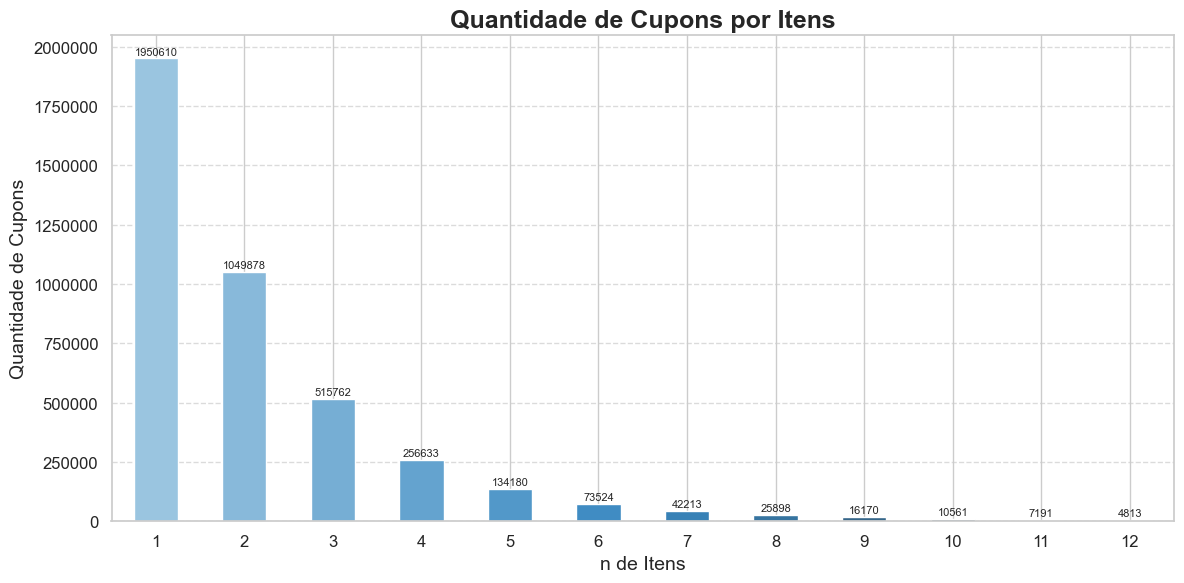

In [54]:

# Definir o estilo
sns.set(style="whitegrid")

# Configurar o tamanho da figura
plt.figure(figsize=(12, 6))

# Criar o gráfico de barras com uma paleta de cores personalizada
ax = sku_coupon_counts.plot(kind='bar', color=sns.color_palette("Blues_d", len(sku_coupon_counts)))

# Adicionar títulos e rótulos com fontes maiores
plt.title('Quantidade de Cupons por Itens', fontsize=18, fontweight='bold')
plt.xlabel('n de Itens', fontsize=14)
plt.ylabel('Quantidade de Cupons', fontsize=14)

# Rotacionar os rótulos do eixo X se necessário
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Adicionar valores no topo de cada barra
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=8)

# Ajustar o formato dos números no eixo Y
plt.ticklabel_format(style='plain', axis='y')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
n=4
cupom_df[cupom_df['COD_SKU'] == n]['COD_CUPOM_LOJA'].nunique()

In [29]:
sample_size = 10_000
results = {}
for n in np.arange(start=2, stop=13):
    print(f'\nQuantidade de itens diferentes por cupom: {n}')

    cupom_lst = []
    if len(cupom_df[cupom_df['COD_SKU'] == n]) < sample_size:
        cupom_lst = cupom_df[cupom_df['COD_SKU'] == n]['COD_CUPOM_LOJA']
    else: 
        cupom_lst = cupom_df[cupom_df['COD_SKU'] == n].sample(n=sample_size)['COD_CUPOM_LOJA']

    r_filter = (rules['confidence'] > .1)
    filtered_rules = rules[r_filter]
    eval_df, avg_df = evalSuggestions(vendas[vendas['COD_CUPOM_LOJA'].isin(cupom_lst)], products, filtered_rules)

    results[n] = {'eval_df':eval_df, 'avg_df':avg_df}



Quantidade de itens diferentes por cupom: 2


Avaliando Recomendações: 100%|██████████| 10000/10000 [01:15<00:00, 132.20it/s]


Métricas Médias:
precision: 0.0903
recall: 0.1507
f1-score: 0.1044
accuracy: 0.0781

Quantidade de itens diferentes por cupom: 3


Avaliando Recomendações: 100%|██████████| 10000/10000 [01:36<00:00, 103.83it/s]


Métricas Médias:
precision: 0.1101
recall: 0.1446
f1-score: 0.1143
accuracy: 0.0792

Quantidade de itens diferentes por cupom: 4


Avaliando Recomendações: 100%|██████████| 10000/10000 [01:45<00:00, 94.90it/s]


Métricas Médias:
precision: 0.1297
recall: 0.1381
f1-score: 0.1232
accuracy: 0.0826

Quantidade de itens diferentes por cupom: 5


Avaliando Recomendações: 100%|██████████| 10000/10000 [01:56<00:00, 85.84it/s]


Métricas Médias:
precision: 0.1442
recall: 0.1266
f1-score: 0.1251
accuracy: 0.0824

Quantidade de itens diferentes por cupom: 6


Avaliando Recomendações: 100%|██████████| 10000/10000 [02:07<00:00, 78.17it/s]


Métricas Médias:
precision: 0.1532
recall: 0.1158
f1-score: 0.1229
accuracy: 0.0797

Quantidade de itens diferentes por cupom: 7


Avaliando Recomendações: 100%|██████████| 10000/10000 [02:25<00:00, 68.75it/s]


Métricas Médias:
precision: 0.1620
recall: 0.1111
f1-score: 0.1241
accuracy: 0.0801

Quantidade de itens diferentes por cupom: 8


Avaliando Recomendações: 100%|██████████| 10000/10000 [02:30<00:00, 66.66it/s]


Métricas Médias:
precision: 0.1689
recall: 0.1053
f1-score: 0.1227
accuracy: 0.0784

Quantidade de itens diferentes por cupom: 9


Avaliando Recomendações: 100%|██████████| 10000/10000 [02:36<00:00, 64.00it/s]


Métricas Médias:
precision: 0.1746
recall: 0.0993
f1-score: 0.1206
accuracy: 0.0760

Quantidade de itens diferentes por cupom: 10


Avaliando Recomendações: 100%|██████████| 10000/10000 [02:43<00:00, 61.00it/s]


Métricas Médias:
precision: 0.1778
recall: 0.0944
f1-score: 0.1183
accuracy: 0.0739

Quantidade de itens diferentes por cupom: 11


Avaliando Recomendações: 100%|██████████| 7191/7191 [02:03<00:00, 58.11it/s]


Métricas Médias:
precision: 0.1852
recall: 0.0901
f1-score: 0.1165
accuracy: 0.0716

Quantidade de itens diferentes por cupom: 12


Avaliando Recomendações: 100%|██████████| 4813/4813 [01:26<00:00, 55.95it/s]

Métricas Médias:
precision: 0.1874
recall: 0.0874
f1-score: 0.1154
accuracy: 0.0705


In [ ]:
keys = list(results.keys())
precision_values = [results[key]['avg_df']['precision'] for key in keys]
recall_values = [results[key]['avg_df']['recall'] for key in keys]
f1_values = [results[key]['avg_df']['f1-score'] for key in keys]
accuracy_values = [results[key]['avg_df']['accuracy'] for key in keys]

# Plotting the performance measures
plt.figure(figsize=(10, 6))
plt.plot(keys, precision_values, marker='o', label='Precision')
plt.plot(keys, recall_values, marker='o', label='Recall')
plt.plot(keys, f1_values, marker='o', label='F1-Score')
plt.plot(keys, accuracy_values, marker='o', label='Accuracy')

# Adding labels and legend
plt.title('Desempenho por grupo')
plt.xlabel('Grupo (N de Itens por cupom)')
plt.ylabel('Valor')
plt.xticks(keys)
plt.legend()
plt.grid(True)
plt.show()

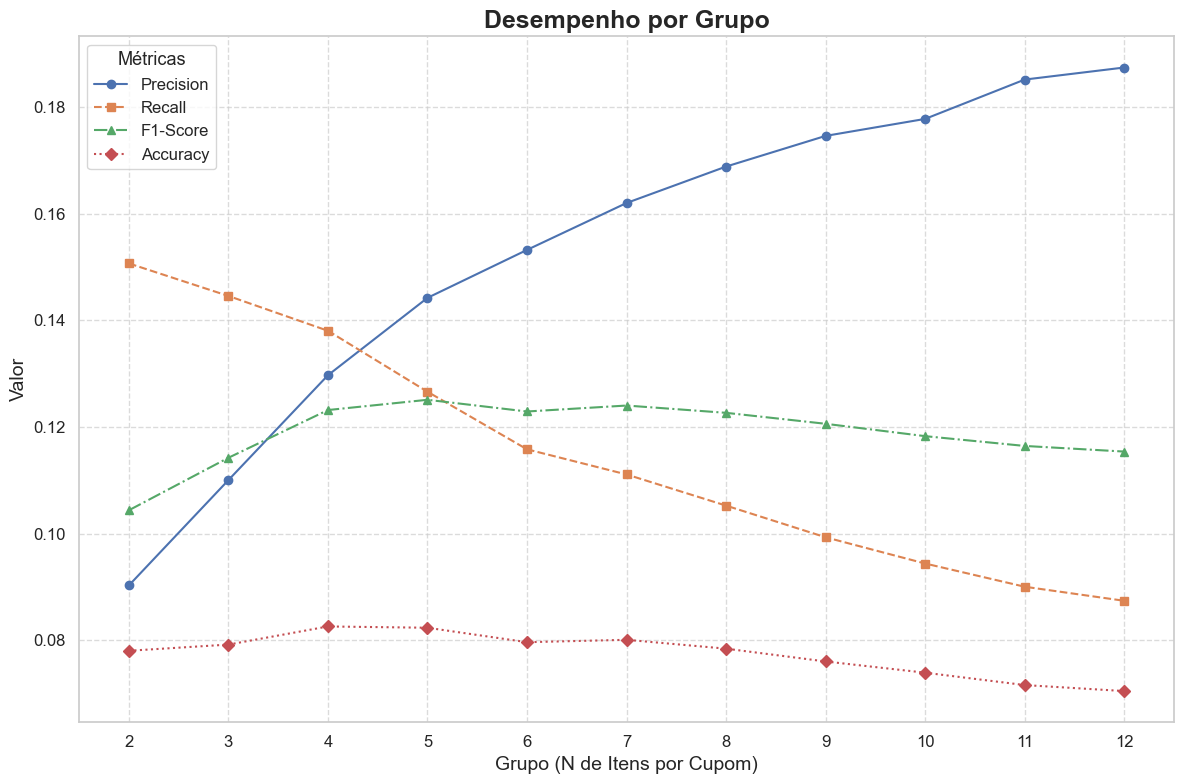

In [34]:
# Definir o estilo
sns.set(style="whitegrid")

# Preparar os dados
keys = list(results.keys())
precision_values = [results[key]['avg_df']['precision'] for key in keys]
recall_values = [results[key]['avg_df']['recall'] for key in keys]
f1_values = [results[key]['avg_df']['f1-score'] for key in keys]
accuracy_values = [results[key]['avg_df']['accuracy'] for key in keys]

# Configurar o tamanho da figura
plt.figure(figsize=(12, 8))

# Definir paleta de cores
palette = sns.color_palette("deep", 4)

# Plotar as métricas com estilos aprimorados
plt.plot(keys, precision_values, marker='o', linestyle='-', color=palette[0], label='Precision')
plt.plot(keys, recall_values, marker='s', linestyle='--', color=palette[1], label='Recall')
plt.plot(keys, f1_values, marker='^', linestyle='-.', color=palette[2], label='F1-Score')
plt.plot(keys, accuracy_values, marker='D', linestyle=':', color=palette[3], label='Accuracy')

# Adicionar títulos e legendas com fontes maiores
plt.title('Desempenho por Grupo', fontsize=18, fontweight='bold')
plt.xlabel('Grupo (N de Itens por Cupom)', fontsize=14)
plt.ylabel('Valor', fontsize=14)
plt.xticks(keys, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Métricas', fontsize=12, title_fontsize=13, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [52]:
results[4]['eval_df'][['COD_CUPOM', 'items', 'precision', 'recall', 'f1-score',
       'accuracy', 'recommendations', 'relevant', 'purchased_products', 'recommended_products']].sort_values(by=['accuracy'], ascending=False)#.tail(20)#[8:]

,COD_CUPOM,items,precision,recall,f1-score,accuracy,recommendations,relevant,purchased_products,recommended_products
3323,731764-763,4,1.0,0.75,0.857143,0.75,3,4,"[1004805, 10024613, 10010301, 998644]","[998644, 10024613, 1004805]"
2090,47550-1349,4,1.0,0.75,0.857143,0.75,3,4,"[10024374, 10024376, 10024375, 100012292]","[10024376, 10024374, 10024375]"
1252,292369-1190,4,1.0,0.75,0.857143,0.75,3,4,"[10007088, 10003211, 10026884, 10026744]","[10007088, 10003211, 10026884]"
1220,286417-682,4,1.0,0.75,0.857143,0.75,3,4,"[10089574, 2059, 10089808, 10008482]","[10089808, 2059, 10089574]"
129,11334-190,4,1.0,0.75,0.857143,0.75,3,4,"[10007088, 10104047, 10003211, 10026884]","[10007088, 10003211, 10026884]"
...,...,...,...,...,...,...,...,...,...,...
1559,358889-599,4,0.0,0.00,0.000000,0.00,1,4,"[10028305, 1006767, 100015207, 10034608]",[10032395]
1560,359112-713,4,0.0,0.00,0.000000,0.00,2,4,"[11016, 973, 10086692, 100018056]","[10185, 10095671]"
1561,359142-599,4,0.0,0.00,0.000000,0.00,2,4,"[10024785, 10028705, 10002898, 10106051]","[10024613, 10028707]"
1562,359231-713,4,0.0,0.00,0.000000,0.00,4,4,"[1002783, 10094058, 669, 100015055]","[10090254, 10004993, 100017441, 100013147]"


In [47]:
filtered_rules = rules[rules['lhs'].apply(lambda x: any(sku in x for sku in [91659, 100018365]))]
filtered_rules = filtered_rules.sort_values(by=['support', 'lift', 'confidence', 'conviction'], ascending=False)

filtered_rules

,lhs,rhs,confidence,conviction,lift,rpf,support


In [48]:
cart = [10032109]#, 4264, 100009844, 100027743 
products[products['COD_SKU'].isin(cart)][['COD_SKU', 'SKU', 'PRECO_REGULAR_AVG']]

,COD_SKU,SKU,PRECO_REGULAR_AVG
10767,10032109,PAPEL HIG LOUVRE FOLHA DUPLA 20M 12UN NE,13.072597


In [49]:
suggestions = get_suggestions(cart, rules)
suggestions

,rhs,confidence,conviction,lift
0,10035299,0.631478,2.695690,95.989938
1,10035289,0.619586,2.610255,88.239039
2,10035291,0.617702,2.599793,101.170433
3,100020206,0.548611,2.195025,59.694927
4,100020204,0.524046,2.082660,59.886209
5,100020205,0.496855,1.971479,61.636475
6,10035311,0.494721,1.968710,94.195317


In [50]:
get_recommendations(suggestions, products, discount=.05)[['COD_SKU', 'SKU', 'PRECO_REGULAR_AVG', 'PRECO_COM_DESCONTO']]

,COD_SKU,SKU,PRECO_REGULAR_AVG,PRECO_COM_DESCONTO
0,10035299,SAB ALBANY 85G LIRIO SELVALGEM,1.989737,1.890250
1,10035289,SAB ALBANY 85G FRUTAS VERMELHAS,1.989316,1.889850
2,10035291,SAB ALBANY 85G OLEO DE MACADAMIA,1.989398,1.889928
3,100020206,CR DENT CLOSE UP 70G,3.287680,3.123296
4,100020204,CR DENT CLOSE UP TR,3.284147,3.119940
5,100020205,CR DENT CLOSE UP 70,3.288412,3.123991
6,10035311,SAB ALBANY 85G AMENDOA DOCE E PROTEINA,1.989489,1.890015
